In [1]:
%load_ext autoreload
%autoreload 2

from causalab.tasks.MCQA.causal_models import positional_causal_model
from causalab.tasks.MCQA.counterfactuals import sample_answerable_question

causal_model = positional_causal_model
import random

# Tracing Information in the Residual Stream of Language Models with Activation Patching

In the first notebook of this demo, we introduced (1) a simple multiple choice question answering dataset, (2) a causal model with a single intermediate variable for the **position** of the correct answer, and (3) datasets of original-counterfactual input pairs that can localize the answer variable and the positional variable. We performed interchange interventions on the variables of a causal model. However, any neural network can be easily understood as a causal model, so we can perform interchange interventions on the language model as well. 

In this second notebook, we move on to interchange interventions on the residual stream of language models, which is often called **activation patching** (though other kinds of interventions are described with this term as well). 

To begin, we load in a language model:

In [2]:
from causalab.neural.pipeline import LMPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "meta-llama/Llama-3.2-1B-Instruct"
pipeline = LMPipeline(
    model_name,
    max_new_tokens=1,
    device=device,
    dtype=torch.bfloat16 if device == "cuda" else torch.float32,
    max_length=32,
)
pipeline.tokenizer.padding_side = "left"


def checker(neural_output, causal_output):
    return (
        causal_output.strip() in neural_output["string"].strip()
        or neural_output["string"].strip() in causal_output.strip()
    )


print("DEVICE:", pipeline.model.device)

DEVICE: cuda:0


First, we will construct a counterfactual example and trace the output token from the first to the last layer of the residual stream. The counterfactual we use for this simply replaces the answer token in context with a different token. (This experiment has nothing to do with the positional variable of the causal model)

Run the following to sample an original and counterfactual that the model answers correctly.

In [3]:
import copy

while True:
    original = sample_answerable_question()
    full_setting = causal_model.run_forward(original)
    original["raw_input"] = full_setting["raw_input"]

    # Create a counterfactual by changing the answer to a different option
    counterfactual = copy.deepcopy(original)
    answer_symbol_key = f"symbol{full_setting['answer_position']}"
    new_symbols = list(
        {"A", "B", "C"}.difference({full_setting[answer_symbol_key]})
    )
    counterfactual[answer_symbol_key] = random.choice(new_symbols)
    counterfactual_setting = causal_model.run_forward(counterfactual)
    counterfactual["raw_input"] = counterfactual_setting["raw_input"]

    # Check if the model gets both examples correct
    print("\n" + "=" * 50)
    print("Testing model predictions:")
    print("=" * 50)

    # Test original
    print(full_setting["raw_input"])
    original_pred = pipeline.generate(full_setting["raw_input"])
    original_pred["string"] = pipeline.dump(original_pred["sequences"])
    print(f"\nOriginal prediction: {original_pred['string']}")
    print(f"Causal output: {full_setting['raw_output']}")
    print(original_pred, full_setting["raw_output"])

    # Test counterfactual
    print(counterfactual_setting["raw_input"])
    counterfactual_pred = pipeline.generate(counterfactual_setting["raw_input"])
    print(f"\nCounterfactual prediction: {counterfactual_pred['string']}")
    print(f"Causal output: {counterfactual_setting['raw_output']}")

    if checker(original_pred, full_setting["raw_output"]):
        if checker(counterfactual_pred, counterfactual_setting["raw_output"]):
            break


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Testing model predictions:
The shoe is green. What color is the shoe?
D. orange
U. green
Answer:

Original prediction:  U
Causal output:  U
{'scores': [tensor([[5.0625, 3.1719, 6.2188,  ..., 0.7500, 0.7500, 0.7500]])], 'sequences': tensor([[549]]), 'string': ' U'}  U
The shoe is green. What color is the shoe?
D. orange
C. green
Answer:

Counterfactual prediction:  C
Causal output:  C


## Visualizing the results interchange interventions for a single pair of inputs

We begin with interchange interventions that fix entire residual stream vectors for a single pair on inputs. 
We patch every single token position and every single layer of the residual stream, and plot the resulting output of the language model after intervention:


Running residual stream tracing...
Found 22 token positions


Running interventions:   3%|▎         | 10/374 [00:01<00:39,  9.20it/s]

Running interventions: 100%|██████████| 374/374 [00:41<00:00,  8.93it/s]


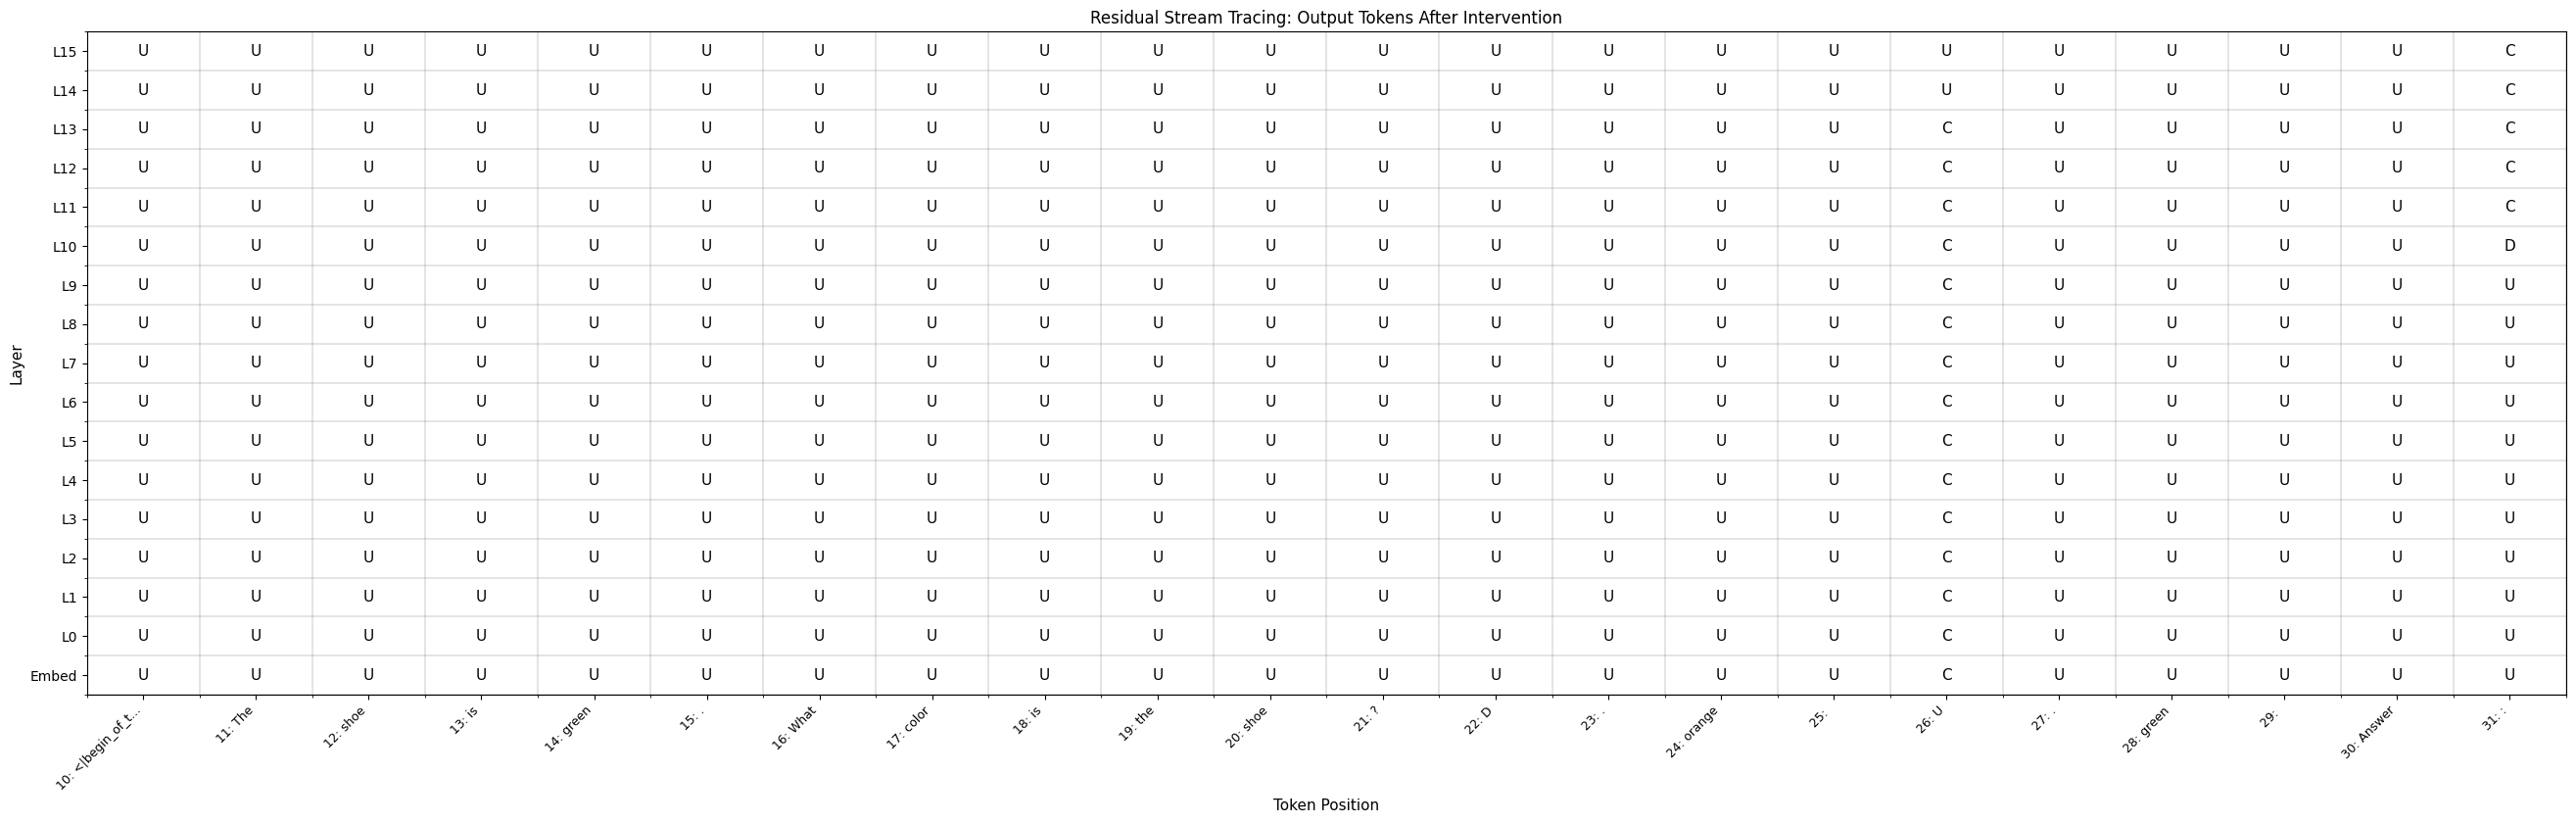


✓ Completed collecting 374 intervention results


In [4]:
# Import the new functional API
from causalab.experiments.jobs.residual_stream_tracing import run_residual_stream_tracing
from causalab.neural.token_position_builder import get_list_of_each_token

# Run the tracing experiment using the new functional API
print("\n" + "=" * 50)
print("Running residual stream tracing...")
print("=" * 50)

# Get all token positions
token_positions = get_list_of_each_token(full_setting["raw_input"], pipeline)
print(f"Found {len(token_positions)} token positions")

# Run tracing experiment
result = run_residual_stream_tracing(
    pipeline=pipeline,
    prompt=full_setting["raw_input"],
    counterfactual_prompt=counterfactual_setting["raw_input"],
    token_positions=token_positions,
    output_dir="./tracing_results",
    layers=None,  # All layers including embeddings
    generate_visualization=True,  # We'll visualize separately below
    verbose=True
)

intervention_results = result["intervention_results"]

print(f"\n✓ Completed collecting {len(intervention_results)} intervention results")

# Takeaways

Observe how the signal flows from input to output. At the first layer, its gauranteed that the answer symbol token contains the signal, because that's where embedding occurs. At the last layer, its gauranteed that the last token contains the signal, because that's where unembedding occurs. However, the middle layers must be understood via experimentation!

For most input pairs, you will see the output signal remain in the residual stream of the answer token util layer 15, at which point it hops over to the last token until the final layer. You might also see an effect from answer token residual stream representations above layer 15, or the period token after the answer token between layers 3 and 10. You also might see something else entirely!

Rerun the above cells to sample new inputs and see the resulting traces. This sort of experiment is excellent for exploration and ideation!